In [ ]:
import numpy as np
from operator import itemgetter


class SVC:
    def fit(self, X, y, selections=None):
        a = np.zeros(X.shape[0])
        ay = 0
        ayx = np.zeros(X.shape[1]) # ある行に対するラグランジュ条数、目的変数(ラベル)、特徴量の掛け算/aiハッシュを計算のため
        yx = y.reshape(-1, 1)*X # 目的変数(ラベル)、特徴量の掛け算/aiハッシュを計算のため
        indices = np.arange(X.shape[0]) # インデックス作成 = サンプル数

        while True:
            ydf = y*(1-np.dot(yx, ayx.T))
            iydf = np.c_[indices, ydf]

            i = int(min(iydf[(y < 0) | (a > 0)],
                        key=itemgetter(1))[0]) # 条件を満たすインデックス抽出
            j = int(max(iydf[(y > 0) | (a > 0)],
                        key=itemgetter(1))[0]) # 条件を満たすインデックス抽出

            # 抽出した２つのインデックスが以下を満たせば終了し、そのaをもって重みを計算する
            if ydf[i] >= ydf[j]:
                break
            
            ay2 = ay - y[i]*a[i] - y[j]*a[j]
            ayx2 = ayx - y[i]*a[i]*X[i, :] - y[j]*a[j]*X[j, :]
            ai = ((1-y[i]*y[j]
                   + y[i]*np.dot(X[i, :] - X[j, :],
                                 X[j, :]*ay2 - ayx2))
                  / ((X[i] - X[j])**2).sum())
            if ai < 0:
                ai = 0
            aj = (-ai * y[i] - ay2) * y[j]
            if aj < 0:
                aj = 0
                ai = (-aj*y[j] - ay2)*y[i]
            ay += y[i]*(ai - a[i]) + y[j]*(aj - a[j]) # 更新後のaで、またaiハットを計算するために更新
            ayx += y[i]*(ai - a[i])*X[i, :] + y[j]*(aj - a[j])*X[j, :]
            if ai == a[i]:# 無限ループにならないようにするため？
                break
            a[i] = ai # 更新
            a[j] = aj # 更新
        self.a_ = a
        ind = a != 0.
        self.w_ = ((a[ind] * y[ind]).reshape(-1, 1)
                   * X[ind, :]).sum(axis=0)
        self.w0_ = (y[ind]
                    - np.dot(X[ind, :], self.w_)).sum() / ind.sum()

    def predict(self, X):
        return np.sign(self.w0_ + np.dot(X, self.w_))

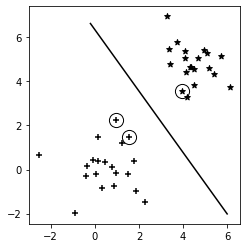

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.axes().set_aspect("equal")
np.random.seed(0)
X0 = np.random.randn(20, 2)
X1 = np.random.randn(20, 2) + np.array([5, 5])
y = np.array([1] * 20 + [-1] * 20)

X = np.r_[X0, X1]
# 学習
model = SVC()
model.fit(X, y)

# テストデータのプロット
plt.scatter(X0[:, 0], X0[:, 1], color="k", marker="+")
plt.scatter(X1[:, 0], X1[:, 1], color="k", marker="*")

# w0 + w1*x0 + w2*x1 = 0　としたときの、片方の変数を固定した時のもう片方の変数の計算
def f(model, x):
    return (-model.w0_ - model.w_[0] * x) / model.w_[1]


x1 = -0.2
x2 = 6
plt.plot([x1, x2], [f(model, x1), f(model, x2)], color="k")
plt.scatter(X[model.a_ != 0, 0], X[model.a_ != 0, 1],
            s=200, color=(0, 0, 0, 0), edgecolor="k", marker="o")

plt.show()
